# 0. Imports

In [2]:
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', 1000)

from sklearn.covariance import EllipticEnvelope

import matplotlib.pyplot as plt

from scipy import stats

from dotenv import load_dotenv
load_dotenv()
import os

# 1. Coletar dados

Fizemos o scrap do site olx, setado para categoria de imoveis em recife, primeiros o extract_single_link.py para pegar os links dos sites, criamos e juntamos um json com esses links e depois fomos em cada um desses link usando scraping.py e criamos um csv com todos os dados colotados.

| Campop               | Descrição                                      |
|----------------------|--------------------------------------------------|
| find_anuncio         | o titulo do anuncio                              |
| find_condominio      | o preço do condominio                            |
| find_descri          | a descrição feita do imovel                      |
| find_endereco        | Endereço = bairro, Cidade, estado, cep           |
| find_iptu            | IPTU                                             |
| find_loc             | geralmente a rua                                 |
| find_m_quadrado      | Tamanho do imóvel em metros quadrados            |
| find_price           | Preço do imóvel                                  |
| find_vendedor        | Informações sobre o vendedor                     |
| is_academia          | Indica se há academia/centro de fitness          |
| is_apartamento       | Indica se é um apartamento                       |
| is_ar_condicionado   | Indica se tem ar condicionado                     |
| is_churrasqueira     | Indica se há churrasqueira                       |
| is_elevador          | Indica se há elevador                            |
| is_mobiliado         | Indica se o imóvel está mobiliado                |
| is_piscina           | Indica se há piscina                             |
| is_portaria          | Indica se há portaria/serviço de portaria        |
| is_profissional      | Indica se o vendedor é um profissional           |
| is_salao_festa       | Indica se há salão de festas/área de eventos     |
| is_varanda           | Indica se há varanda                             |
| n_banheiros          | Número de banheiros                              |
| n_fotos              | Número de fotos no anúncio                       |
| n_garagens           | Número de vagas/garagens                         |
| n_quartos            | Número de quartos                                |

In [6]:
path_raw = os.getenv('PATH_RAW')
df_raw = pd.read_csv(path_raw, sep=',')

In [7]:
df_raw.head(3)

,find_anuncio,find_condominio,find_descri,find_endereco,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos
0,Apartamento para venda com 105 metros quadrado...,R$ 1.100 / mês,Código do anúncio: C6BAD9\n\nO apartamento est...,"Aflitos, Recife, PE, 52050340",R$ 180,Rua da Angustura,105m²,380000,Antônio Luciano Santana da Silva,False,True,False,False,False,False,False,False,True,False,False,3,20,0,3
1,Apartamento para venda possui 51 metros quadra...,R$ 0 / mês,Código do anúncio: S623-1\n\nO apartamento no ...,"Boa Viagem, Recife, PE, 51021130",R$ 0,Rua Coronel Anízio Rodrigues Coelho,51m²,525000,Dream Residence Imóveis Recife,False,True,False,False,False,False,True,False,True,True,False,2,15,1,3
2,Apartamento para venda possui 124 metros quadr...,R$ 822 / mês,Código do anúncio: V2009TS-2225\n\nApartamento...,"Boa Viagem, Recife, PE, 51130000",R$ 291,Avenida Boa Viagem - de 6200/6201 ao fim,124m²,620000,Roberta Gadelha Batista,False,True,False,False,False,False,False,False,True,False,False,2,14,1,3


# 2. Realizar pré-processamento dos dados

In [5]:
df_raw.shape

(5000, 24)

In [153]:
df_0 = df_raw.copy()

Vamos tirar a descrção e anuncio, pois está fora do escopo do projeto fazer analise com esse tipo de texto

In [154]:
df_0 = df_0.drop(['find_anuncio','find_descri'], axis=1) 

Vamos separar o bairro e o cep

In [155]:
df_0[['Bairro','CEP']] = df_0['find_endereco'].str.split(', ', expand=True)[[0,3]]


vamos remover as duplicadas ea coluna de endereço

In [156]:
df_0 = df_0.drop(columns=['find_endereco'])
df_0 = df_0.drop_duplicates()

In [157]:
df_0.shape

(4890, 23)

## 2.0 Tratamento de dados

### 2.0.1 Algumas classes são muito uteis como valor numerico, mas não podem ser totalmente convertidas. exemplo: o numero de quartos tem o campo '5 ou mais' vamos fazer o drop desses valores

In [158]:
df_0 = df_0[df_0['n_quartos'] != '5 ou mais'] # por recomendação do professor
df_0 = df_0[df_0['n_banheiros'] != '5 ou mais']
df_0 = df_0[df_0['n_garagens'] != '5 ou mais']

df_0 = df_0[df_0['find_price'] > 10000]# vamo tirar aguns precos muito absurdos

In [159]:
df_0.shape

(4557, 23)

## 2.1 definição de tipos e criação de novas colunas derivadas

In [160]:
df_0.dtypes

find_condominio       object
find_iptu             object
find_loc              object
find_m_quadrado       object
find_price             int64
find_vendedor         object
is_academia             bool
is_apertamento          bool
is_ar_condicionado      bool
is_churrasqueira        bool
is_elevador             bool
is_mobiliado            bool
is_piscina              bool
is_portaria             bool
is_profissional         bool
is_salao_festa          bool
is_varanda              bool
n_banheiros           object
n_fotos                int64
n_garagens            object
n_quartos             object
Bairro                object
CEP                   object
dtype: object

In [161]:
# deixando como num a coluna find_condominio
df_0['find_condominio'] = df_0['find_condominio'].astype('str').str.replace('R$', '').str.replace(' / mês', '').str.replace('.', '')

# deixando como num a coluna find_iptu
df_0['find_iptu'] = df_0['find_iptu'].astype('str').str.replace('R$ ', '').str.replace('.', '')

# deixando como num a coluna find_m_quadrado
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('str').str.replace('m²', '').str.replace('.', '')

# cast direto colunas(floats devido a conseguir dar cast em NaN)
df_0['find_condominio'] = df_0['find_condominio'].astype('float')
df_0['Bairro'] = df_0['Bairro'].astype('category')
df_0['CEP'] = df_0['CEP'].astype('category')
df_0['find_iptu'] = df_0['find_iptu'].astype('float')
df_0['find_loc'] = df_0['find_loc'].astype('category')
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('float')
df_0['find_price'] = df_0['find_price'].astype('float')
df_0['find_vendedor'] = df_0['find_vendedor'].astype('category')
df_0['is_academia'] = df_0['is_academia'].astype('category')
df_0['is_apertamento'] = df_0['is_apertamento'].astype('category')
df_0['is_ar_condicionado'] = df_0['is_ar_condicionado'].astype('category')
df_0['is_churrasqueira'] = df_0['is_churrasqueira'].astype('category')
df_0['is_elevador'] = df_0['is_elevador'].astype('category')
df_0['is_mobiliado'] = df_0['is_mobiliado'].astype('category')
df_0['is_piscina'] = df_0['is_piscina'].astype('category')
df_0['is_portaria'] = df_0['is_portaria'].astype('category')
df_0['is_profissional'] = df_0['is_profissional'].astype('category')
df_0['is_salao_festa'] = df_0['is_salao_festa'].astype('category')
df_0['is_varanda'] = df_0['is_varanda'].astype('category')
df_0['n_banheiros'] = df_0['n_banheiros'].astype('float')
df_0['n_fotos'] = df_0['n_fotos'].astype('float')
df_0['n_garagens'] = df_0['n_garagens'].astype('float')
df_0['n_quartos'] = df_0['n_quartos'].astype('float')


In [162]:
df_0.dtypes

find_condominio        float64
find_iptu              float64
find_loc              category
find_m_quadrado        float64
find_price             float64
find_vendedor         category
is_academia           category
is_apertamento        category
is_ar_condicionado    category
is_churrasqueira      category
is_elevador           category
is_mobiliado          category
is_piscina            category
is_portaria           category
is_profissional       category
is_salao_festa        category
is_varanda            category
n_banheiros            float64
n_fotos                float64
n_garagens             float64
n_quartos              float64
Bairro                category
CEP                   category
dtype: object

In [163]:
df_0[df_0.select_dtypes(['category']).columns] = df_0.select_dtypes(['category']).apply(lambda x: x.cat.codes)

In [164]:
df_0.dtypes

find_condominio       float64
find_iptu             float64
find_loc                int16
find_m_quadrado       float64
find_price            float64
find_vendedor           int16
is_academia              int8
is_apertamento           int8
is_ar_condicionado       int8
is_churrasqueira         int8
is_elevador              int8
is_mobiliado             int8
is_piscina               int8
is_portaria              int8
is_profissional          int8
is_salao_festa           int8
is_varanda               int8
n_banheiros           float64
n_fotos               float64
n_garagens            float64
n_quartos             float64
Bairro                   int8
CEP                     int16
dtype: object

## 2.2 Tratamento de dados ausentes
  - vamos fazer a imputação das únicas 3 colunas que apresentam preenchimento vazio
    - find_m_quadrado
    - n_banheiros
    - n_garagens

In [165]:
df_0.isna().sum()

find_condominio         0
find_iptu               0
find_loc                0
find_m_quadrado        32
find_price              0
find_vendedor           0
is_academia             0
is_apertamento          0
is_ar_condicionado      0
is_churrasqueira        0
is_elevador             0
is_mobiliado            0
is_piscina              0
is_portaria             0
is_profissional         0
is_salao_festa          0
is_varanda              0
n_banheiros             7
n_fotos                 0
n_garagens            116
n_quartos               0
Bairro                  0
CEP                     0
dtype: int64

### 2.2.1 Removendo colunas pelo knnimputer

In [166]:
from fancyimpute import KNN

df_0_knn = KNN(k=2).fit_transform(df_0)

Imputing row 1/4557 with 0 missing, elapsed time: 3.548
Imputing row 101/4557 with 0 missing, elapsed time: 3.558
Imputing row 201/4557 with 0 missing, elapsed time: 3.559
Imputing row 301/4557 with 0 missing, elapsed time: 3.559
Imputing row 401/4557 with 0 missing, elapsed time: 3.559
Imputing row 501/4557 with 0 missing, elapsed time: 3.559
Imputing row 601/4557 with 0 missing, elapsed time: 3.559
Imputing row 701/4557 with 0 missing, elapsed time: 3.559
Imputing row 801/4557 with 0 missing, elapsed time: 3.559
Imputing row 901/4557 with 0 missing, elapsed time: 3.559
Imputing row 1001/4557 with 0 missing, elapsed time: 3.559
Imputing row 1101/4557 with 0 missing, elapsed time: 3.559
Imputing row 1201/4557 with 0 missing, elapsed time: 3.559
Imputing row 1301/4557 with 0 missing, elapsed time: 3.559
Imputing row 1401/4557 with 0 missing, elapsed time: 3.559
Imputing row 1501/4557 with 0 missing, elapsed time: 3.559
Imputing row 1601/4557 with 0 missing, elapsed time: 3.559
Imputing 

In [167]:
df_0 = pd.DataFrame(data=df_0_knn[0:,0:],columns=df_0.columns)

In [168]:
df_0.isna().sum()

find_condominio       0
find_iptu             0
find_loc              0
find_m_quadrado       0
find_price            0
find_vendedor         0
is_academia           0
is_apertamento        0
is_ar_condicionado    0
is_churrasqueira      0
is_elevador           0
is_mobiliado          0
is_piscina            0
is_portaria           0
is_profissional       0
is_salao_festa        0
is_varanda            0
n_banheiros           0
n_fotos               0
n_garagens            0
n_quartos             0
Bairro                0
CEP                   0
dtype: int64

## 2.3 Normalização e discretização dos dados

<Axes: xlabel='dist_find_m_quadrado'>

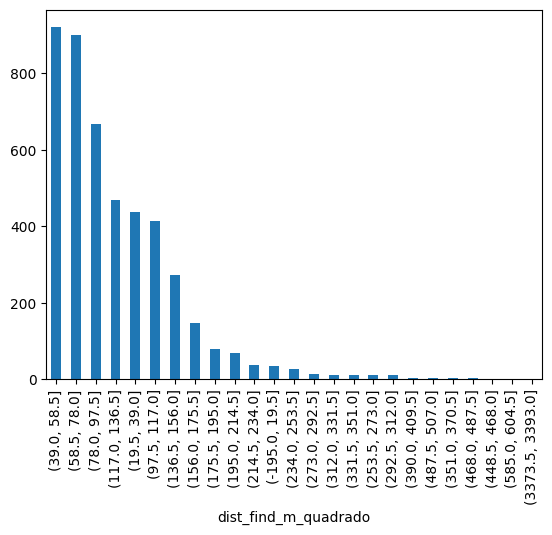

In [169]:
# fazendo a discretização do find_m_quadrado para entender melhor distribuição pelos segmentos
df_disc = df_0.copy()
df_disc['dist_find_m_quadrado'] = pd.cut(df_disc['find_m_quadrado'], bins=10000)

df_disc['dist_find_m_quadrado'].value_counts()[:25].plot(kind='bar')

In [170]:
# minmax em todo o dataframe
df_0_norm = (df_0 - df_0.min()) / (df_0.max() - df_0.min()).copy()

In [171]:
df_0_norm.describe()

,find_condominio,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos,Bairro,CEP
count,4557.000000,4.557000e+03,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000
mean,0.001111,6.985622e-04,0.501175,0.000691,0.261314,0.490102,0.468071,0.964670,0.215054,0.436910,0.677200,0.062761,0.633092,0.614000,0.979372,0.639456,0.346939,0.456422,0.781249,0.364362,0.667654,0.360121,0.467776
std,0.024979,1.536719e-02,0.282680,0.014812,0.175458,0.276655,0.499034,0.184633,0.410905,0.496058,0.467598,0.242558,0.482014,0.486884,0.142150,0.480211,0.476048,0.236917,0.251340,0.166026,0.219514,0.298105,0.258175
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000001,9.259251e-07,0.266588,0.000277,0.143434,0.245409,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.250000,0.650000,0.250000,0.500000,0.097222,0.326555
50%,0.000114,1.851850e-06,0.502370,0.000395,0.195972,0.497496,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.500000,0.900000,0.250000,0.750000,0.208333,0.429426
75%,0.000504,2.787034e-04,0.744076,0.000615,0.333333,0.714524,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.950000,0.500000,0.750000,0.569444,0.671053
max,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2.4 Limpeza dos dados

In [172]:
df_1 = df_0.copy()
df_1_norm = df_0_norm.copy()

### 2.4.1 univariado

<Axes: >

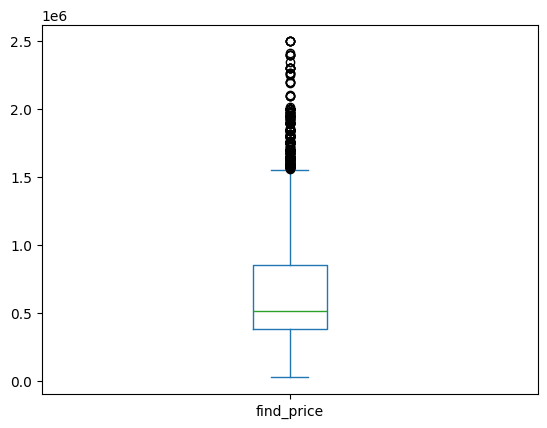

In [173]:
df_1['find_price'].plot.box()

<Axes: >

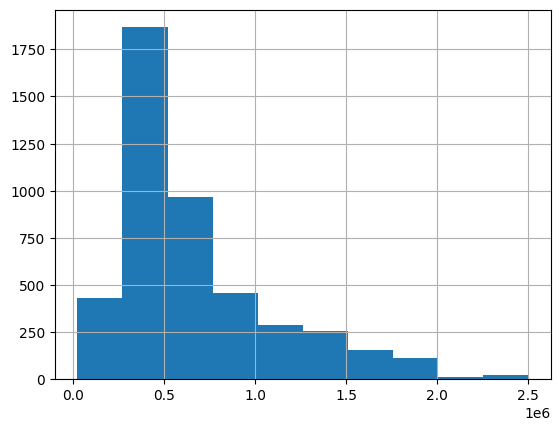

In [174]:
df_1['find_price'].hist()

In [175]:
from numpy import log10

df_1['log_find_price'] = log10(df_1['find_price'])

<Axes: >

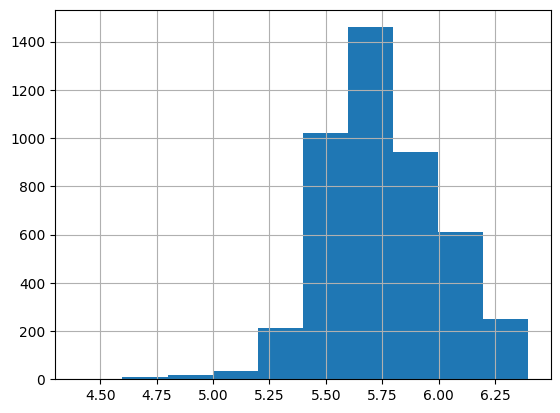

In [176]:
# sem melhoras significativas no shape da distribuição, vamos usar o find_price
df_1['log_find_price'].hist()

In [177]:
q1 = df_1['find_price'].quantile(q=0.25)
q3 = df_1['find_price'].quantile(q=0.75)
iqr = q3 - q1
print(iqr)


470000.0


In [178]:
# aplicando metodo tukey
print(len(df_1))
df_1 = df_1[(df_1['find_price'] > (q1-1.5*iqr)) & (df_1['find_price'] < (q3+1.5*iqr))]
print(len(df_1))

4557
4294


### 2.4.2 bivariado

<Axes: xlabel='find_price', ylabel='n_banheiros'>

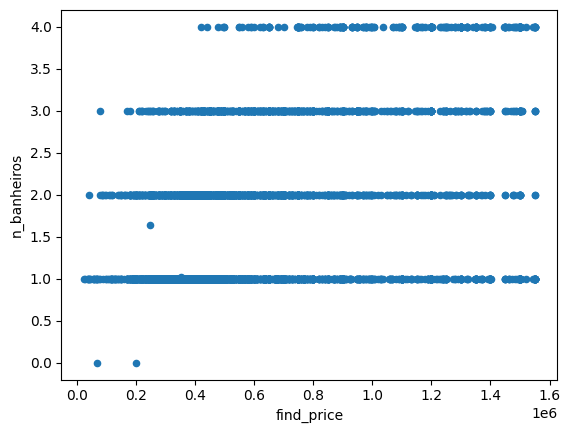

In [182]:
df_1.plot.scatter(x='find_price', y='n_banheiros')

In [183]:
df_1['price_qtdbanheiros'] = df_1['find_price'] / df_1['n_banheiros']

<Axes: >

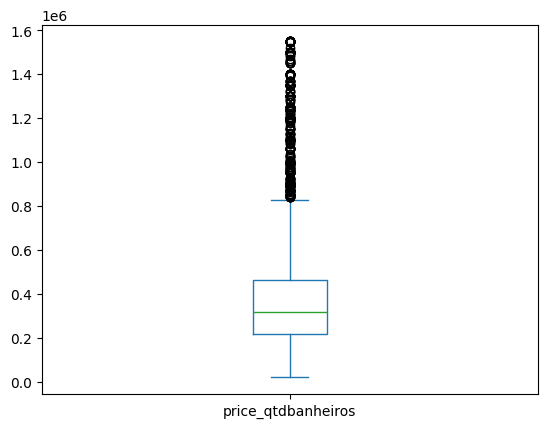

In [184]:
df_1['price_qtdbanheiros'].plot.box()

In [185]:
mad = abs(df_1['price_qtdbanheiros'] - df_1['price_qtdbanheiros'].median()).median()*(1/0.6745)

In [186]:
print(f'volumetria antes: {len(df_1)}')
df_1 = df_1[abs(df_1['price_qtdbanheiros']-df_1['price_qtdbanheiros'].median())/mad < 3.5]
print(f'volumetria depois: {len(df_1)}')

volumetria antes: 4294
volumetria depois: 4047


### 2.4.3 multivariado

In [187]:
detector = EllipticEnvelope(contamination=0.01)
detector.fit(df_1)

EllipticEnvelope(contamination=0.01)

In [188]:
df_1['outlier'] = detector.predict(df_1)
df_1.head(3)

C:\Users\davim\AppData\Local\Temp\ipykernel_3712\1587711812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['outlier'] = detector.predict(df_1)


,find_condominio,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos,Bairro,CEP,log_find_price,price_qtdbanheiros,outlier
0,1100.0,180.0,797.0,105.0,380000.0,59.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,20.0,0.0,3.0,0.0,660.0,5.579784,126666.666667,1
1,0.0,0.0,317.0,51.0,525000.0,147.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,15.0,1.0,3.0,7.0,356.0,5.720159,262500.000000,1
2,822.0,291.0,25.0,124.0,620000.0,489.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,14.0,1.0,3.0,7.0,449.0,5.792392,310000.000000,1


In [189]:
print(f'volumetria antes: {len(df_1)}')
df_1 = df_1[df_1['outlier'] != -1]
print(f'volumetria depois: {len(df_1)}')

volumetria antes: 4047
volumetria depois: 4006


# 3. Apresentar estatísticas descritivas dos dados com visualizações

In [190]:
df_2 = df_1.copy()
df_2_norm = df_1_norm.copy()

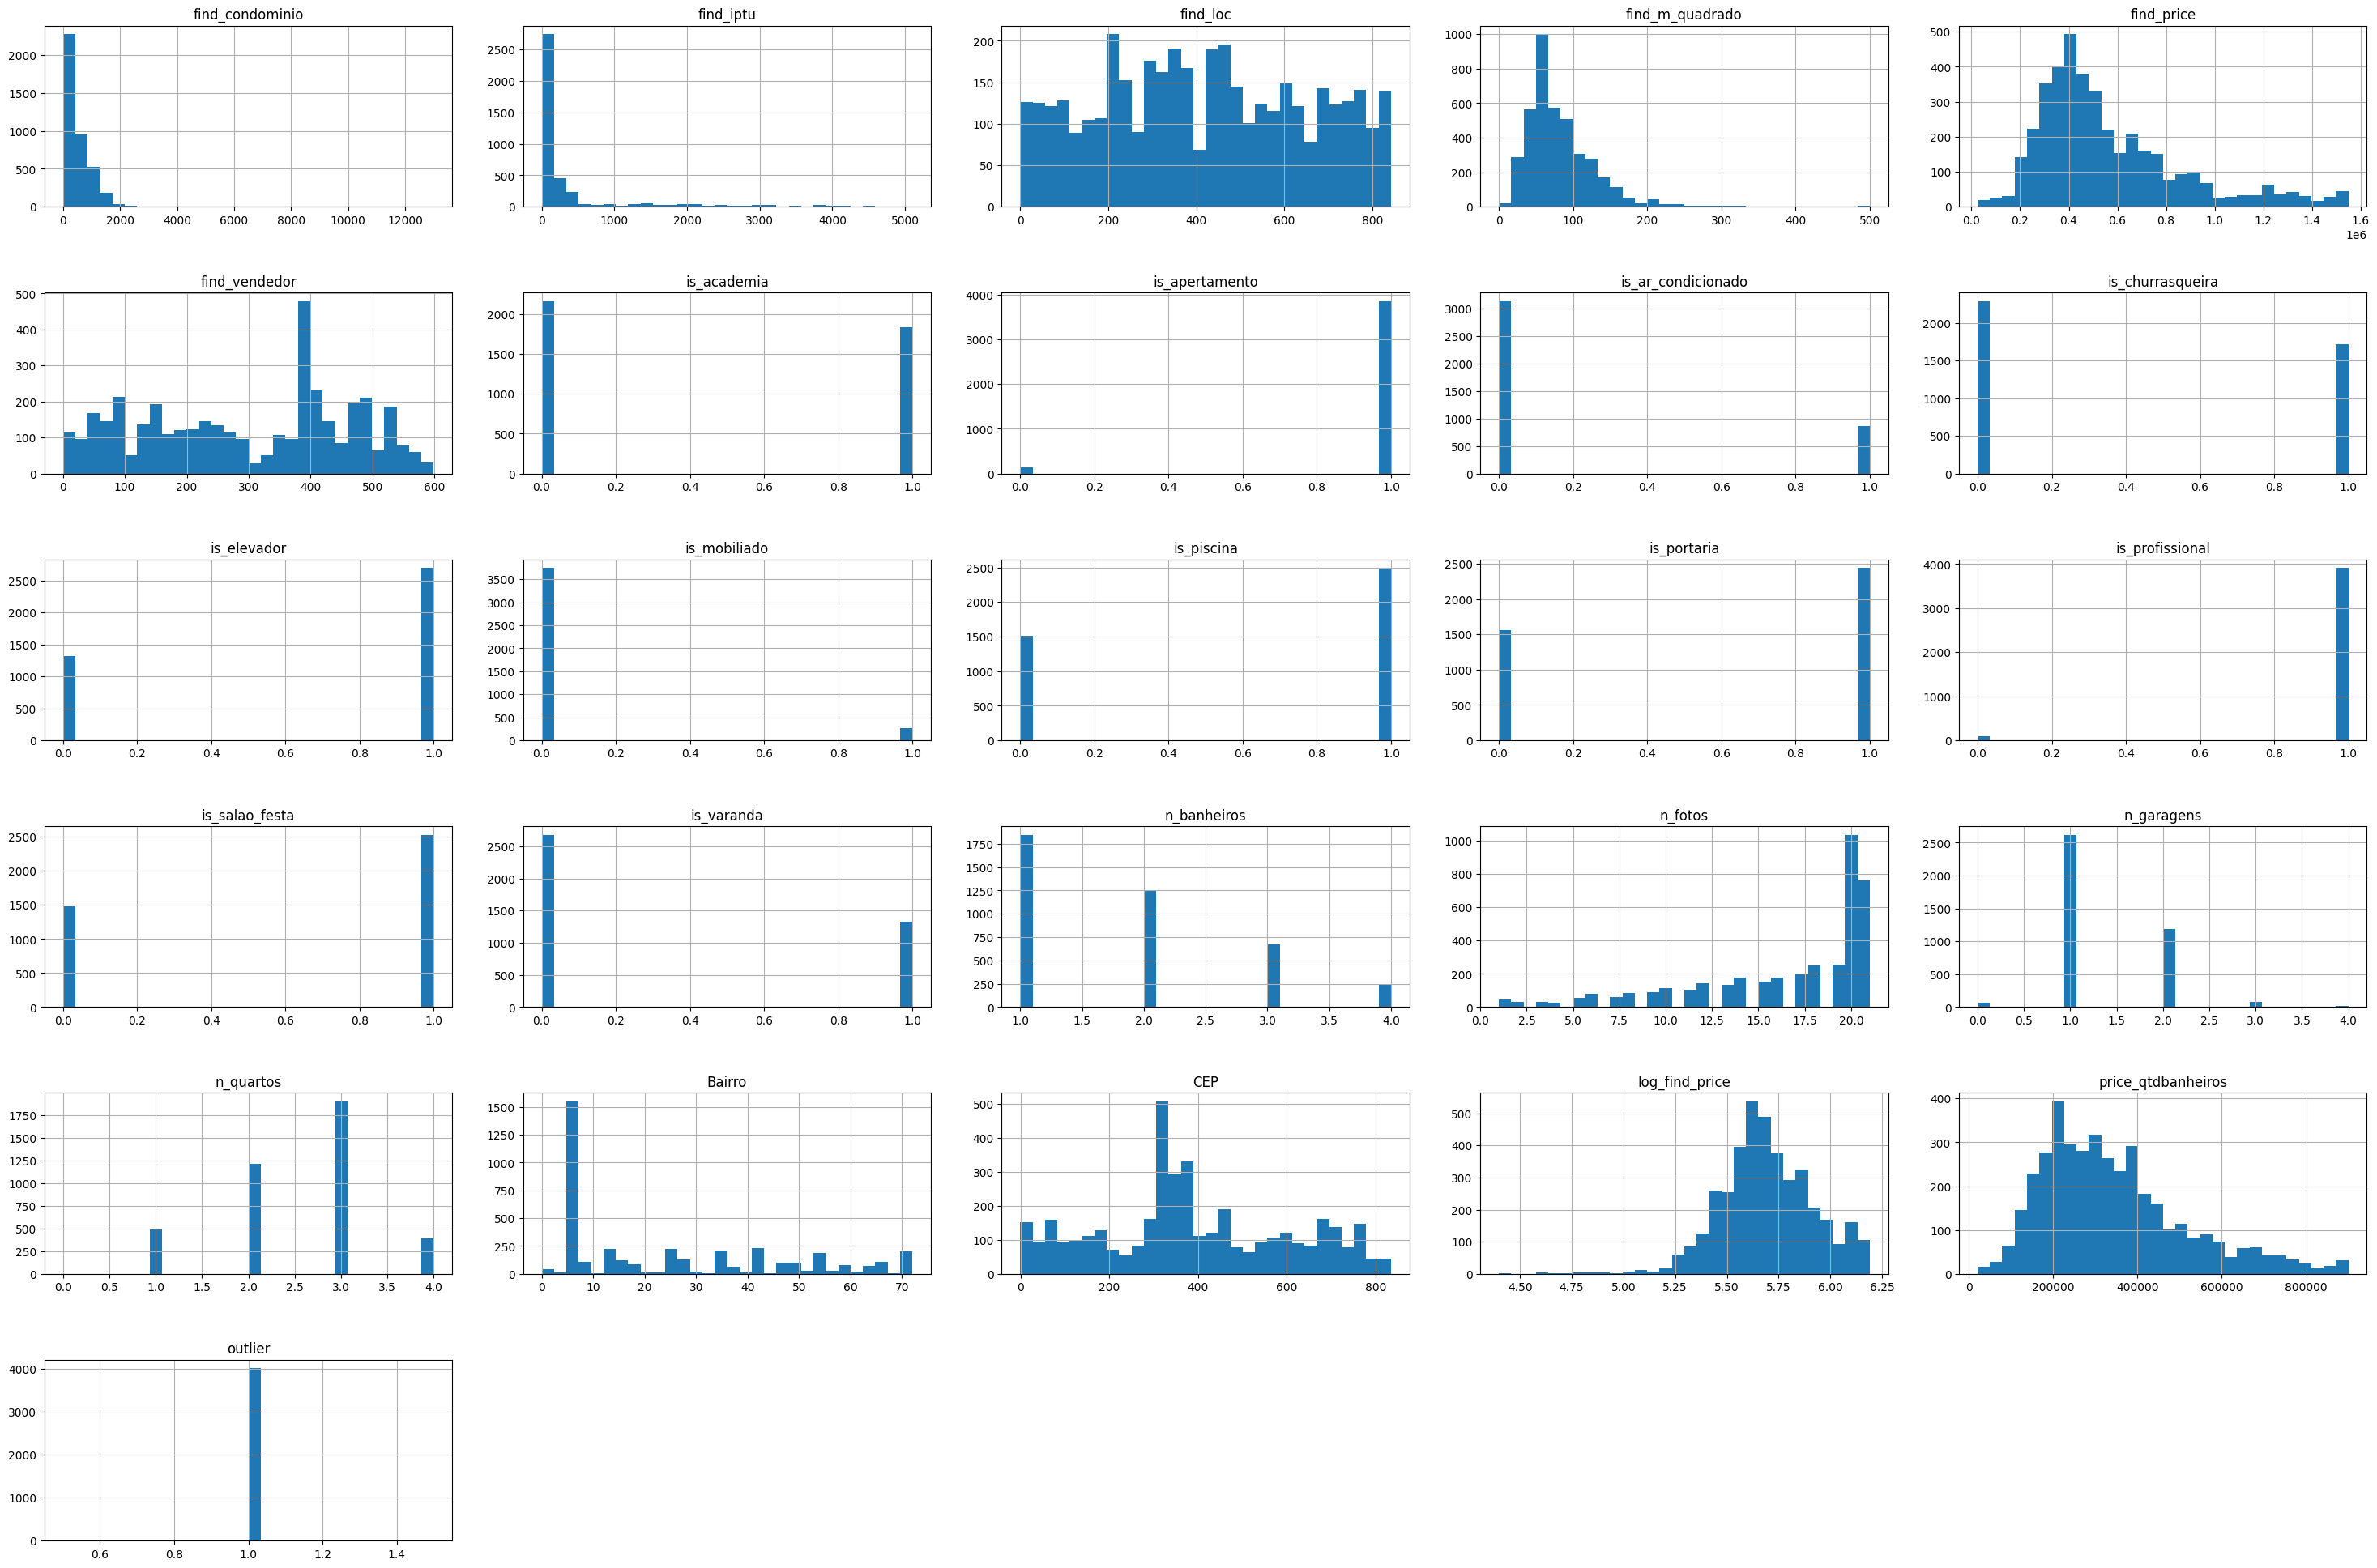

In [191]:
# TODO: escrever possíveis insights

df_2.hist(figsize=(30, 20), bins=30)

plt.tight_layout(pad=3.0)

In [192]:
df_2.describe()

,find_condominio,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos,Bairro,CEP,log_find_price,price_qtdbanheiros,outlier
count,4006.000000,4006.000000,4006.000000,4006.000000,4.006000e+03,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.0
mean,415.074388,379.050674,418.005492,82.201976,5.598468e+05,297.031203,0.459561,0.963305,0.216176,0.428357,0.672741,0.064154,0.622566,0.609835,0.977034,0.631802,0.331253,1.823430,16.422117,1.339864,2.548677,25.964803,390.001747,5.690949,343792.777219,1.0
std,565.940121,857.577459,234.492486,48.463790,2.978166e+05,166.021304,0.498424,0.188035,0.411687,0.494903,0.469271,0.245057,0.484805,0.487848,0.149812,0.482376,0.470723,0.912146,5.092532,0.575614,0.832548,21.562626,214.355691,0.226819,171648.976893,0.0
min,-1.000000,-1.000000,0.000000,0.000000,2.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,4.397940,21000.000000,1.0
25%,0.000000,0.000000,223.000000,51.000000,3.600000e+05,147.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,14.000000,1.000000,2.000000,7.000000,262.250000,5.556303,216666.666667,1.0
50%,100.000000,1.000000,412.500000,69.000000,4.706080e+05,324.500000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,19.000000,1.000000,3.000000,15.000000,361.000000,5.672659,307710.500000,1.0
75%,750.000000,226.000000,613.000000,100.000000,6.900000e+05,432.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,20.000000,2.000000,3.000000,41.000000,559.000000,5.838849,430000.000000,1.0
max,13000.000000,5100.000000,842.000000,500.000000,1.550000e+06,599.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,21.000000,4.000000,4.000000,72.000000,835.000000,6.190332,900001.000000,1.0


# 4. Realizar teste de hipóteses para comparação de valores de categorias e visualizar diferenças

In [193]:
df_3 = df_2.copy()
df_3_norm = df_2_norm.copy()

## 4.1 Existe diferença significativa no preço médio entre imóveis com piscina e imóveis sem piscina?
  - Mann Whitney u-test
    - Grupos não pariados
    - Teste não paramétrico
  - (H₀): Não há diferença significativa no preço médio entre imóveis com piscina e imóveis sem piscina.

In [194]:
precos_com_piscina = df_3[df_3['is_piscina'] == 1]['find_price']
precos_sem_piscina = df_3[df_3['is_piscina'] == 0]['find_price']

In [195]:
stats.shapiro(precos_com_piscina) # rejeita hip nula -> não apresenta dist normal

ShapiroResult(statistic=0.8628364166988424, pvalue=3.03883891582451e-42)

In [196]:
stats.shapiro(precos_sem_piscina) # rejeita hip nula -> não apresenta dist normal

ShapiroResult(statistic=0.9186619034364446, pvalue=8.873059275239887e-28)

<Axes: >

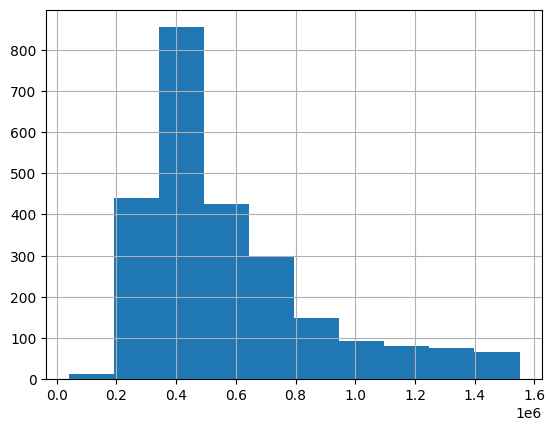

In [197]:
precos_com_piscina.hist()

<Axes: >

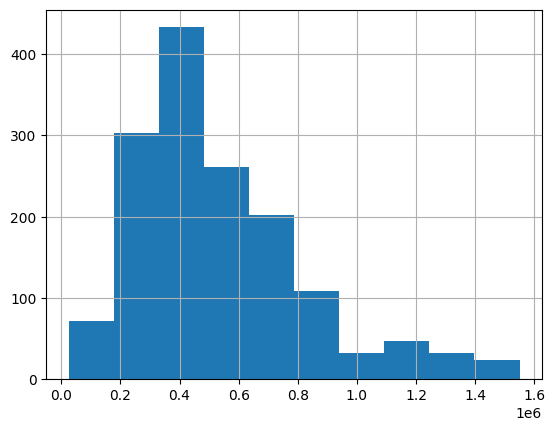

In [198]:
precos_sem_piscina.hist()

In [199]:
stat, p_value = stats.mannwhitneyu(precos_com_piscina, precos_sem_piscina, alternative='two-sided')
print(f"Statistic: {stat}, P-value: {p_value}") # Rejeitamos a hipótese nula, ou seja, há uma diferença significativa no preço médio entre imóveis com e sem piscina.

Statistic: 2071987.5, P-value: 1.4675112656766247e-07
